CartPole NN - Policy gradients
================================
Le réseau va être entrainé de manière à valoriser les bonnes actions.  

A propos de CartPole-v0 :  
https://github.com/openai/gym/wiki/CartPole-v0

**Note :** Le simulateur Gym a besoin d'un serveur X

In [1]:
import tensorflow as tf
import numpy as np
import gym
import math
import random
import os
import logging
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation, rc
from itertools import chain

import deepmods.notebook as ooo

ooo.init(id='19.5.0', save_figs=True)

build_model      = False
save_model       = False
save_log         = False

build_animations = True
save_animations  = True


Deepmod by pjluc 2019
  Version          : 0.4.1
  Run time         : Tuesday 17 September 2019, 11:44:33
  Run directory    : ./run/lab-19.5.0
  Save figs        : True
  Matplotlib style : deepmods/talk.mplstyle
  Hide warning     : True

TensorFlow version :  1.14.0
Keras version      :  2.2.4-tf

Init done.


In [2]:
# ---- Architecture du réseau
#
n_inputs      = 4     # cart position, cart vitesse, pole angle, pole velocity
n_hidden1     = 6
n_hidden2     = 6
n_outputs     = 1
learning_rate = 0.01
seed          = 37

# ---- Paramètres d'entrainement
#
max_episode_steps  = 1000
n_games_per_update = 10
n_max_steps        = 1000
n_iterations       = 200
save_iterations    = 10
discount_rate      = 0.98

save_model = True
save_log   = True

In [3]:
# Calcul des récompenses en tenant compte du taux de rabais
#  
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

# Calcul et normalisation des récompenses
#
def discount_and_normalize_rewards(all_rewards, discount_rate):
    # Calcul des récompenses, avec rabais
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    # Normalisation
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std  = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

Construction du modèle
----------------------

In [4]:
if build_model:
    
    # ---- Reset random generators
    #
    tf.set_random_seed(seed)
    np.random.seed(seed)

    # ---- Build the neural network
    #      output = probabilité d'aller à gauche

    tf.reset_default_graph()

    initializer = tf.variance_scaling_initializer()

    X           = tf.placeholder(tf.float32, shape=[None, n_inputs])
    steps_plh   = tf.placeholder(tf.int32, shape=[n_games_per_update,None], name="Steps")
    rewards_plh = tf.placeholder(tf.float32, shape=[n_games_per_update,None], name="Rewards")


    with tf.name_scope("dnn"):
        hidden1 = tf.layers.dense(X,       n_hidden1, name="hidden1",   activation=tf.nn.elu, kernel_initializer=initializer)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",   activation=tf.nn.elu, kernel_initializer=initializer)
        logits  = tf.layers.dense(hidden2, n_outputs, name="outputs")
        outputs = tf.nn.sigmoid(logits) 

    # ---- Choix de l'action
    #      Basée sur les probabilités proposées par le réseau

    p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
    action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

    # Si action=0 (gauche), alors la probabilité d'aller à gauche doit être à 1
    # Si action=1 (droite), alors la probabilité d'aller à gauche doit être à 0
    y = 1. - tf.to_float(action)

    # ---- Apprentissage
    #      Optimisation des gradients

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
    optimizer     = tf.train.AdamOptimizer(learning_rate)

    # On calcul les gradients, mais sans les appliquer tout de suite
    grads_and_vars = optimizer.compute_gradients(cross_entropy)
    gradients      = [grad for grad,variable in grads_and_vars]

    gradient_placeholders = []   # Liste de placeholder
    grads_and_vars_feed   = []   # Liste de (placeholder, variable)

    for grad,variable in grads_and_vars:
        gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
        gradient_placeholders.append(gradient_placeholder)
        grads_and_vars_feed.append((gradient_placeholder, variable))

    training_op = optimizer.apply_gradients(grads_and_vars_feed)

    # ----- Stats
    #
    mean_steps_op   = tf.reduce_mean(steps_plh)
    mean_rewards_op = tf.reduce_mean(rewards_plh)

    mean_steps_summary   = tf.summary.scalar('STP', mean_steps_op)
    mean_rewards_summary = tf.summary.scalar('RWD', mean_rewards_op)

    now = datetime.utcnow().strftime("%Y-%m-%d-%Hh%Mm%Ss")
    if save_log:
        file_writer = tf.summary.FileWriter(ooo.get_log_dir(), tf.get_default_graph())

    # ----- Création d'une collection d'ops pour faciliter
    #       toute réutilisation future
    #
    for op in (X, action):
        tf.add_to_collection("run_model_ops", op)

    init = tf.global_variables_initializer()
    saver = tf.train.Saver(max_to_keep=50)
    
else:
    print('Build model is False.')

Build model is False.


Entrainement du modèle
---------------------
Visualiseur de courbe : https://www.desmos.com/calculator

In [6]:
%%time

if build_model:
    
    env = gym.make("CartPole-v0")
    env._max_episode_steps = max_episode_steps

    # ---- Run

    print('Run...')
    with tf.Session() as sess:
        init.run()

        # ----- On fait un certain nombre de manches.
        #       A l'issue de chaque manche, on fera une mise à jour du modèle
        #
        for iteration in range(n_iterations+1):

            print("\rIteration: {:03d} ".format(iteration), end="")
            all_rewards       = []   # Toutes les recompenses, pour chaque étape de chaque partie
            all_gradients     = []   # Tous les gradients, pour chaque étape de chaque partie
            iteration_rewards = []   # Récompenses, pour chaque partie
            iteration_steps   = []   # Nombre d'étapes, pour chaque partie

            # ----- Pour chaque manche, on va faire un certain nombre de partie 
            #       dont on va conserver les récompenses et et les gradients
            #
            for game in range(n_games_per_update):

                current_rewards   = []
                current_gradients = []
                obs = env.reset()
                #
                # -- On joue chaque partie en mémorisant 
                #    les récompenses et les gradients de chaque étape
                #
                for step in range(n_max_steps):
                    # On récupère : action,gradient
                    action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                    # On fait évoluer l'environnement avec l'action 
                    obs, reward, done, info   = env.step(action_val[0][0])
                    x,a=obs[0],obs[2]
                    # On mémorise la récompense
                    reward+=  0.5*math.exp(-2*x*x)   # prime de position
                    current_rewards.append(reward)
                    # On mémorise les gradients
                    current_gradients.append(gradients_val)
                    # Si la partie est perdue, on arrête...
                    if done:
                        break

                # -- On mémorise les récomprenses et les gradients
                #    de chaque étape de chaque partie
                #
                all_rewards.append(current_rewards)
                all_gradients.append(current_gradients)
                iteration_steps.append(step)
                iteration_rewards.append(sum(current_rewards))

            # ----- A l'issue de chaque manche, on va calculer
            #       les gradients à appliquer et les appliquer
            #
            all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
            feed_dict = {}
            # -- Pour chaque variable
            for var_i,gradient_placeholder in enumerate(gradient_placeholders):
                var_gradients=[]
                # -- Pour chaque partie
                for game_i,rewards in enumerate(all_rewards):
                    # -- Pour chaque étape
                    for step, reward in enumerate(rewards):
                        # On calcul la récompense*gradient 
                        v=reward * all_gradients[game_i][step][var_i]
                        var_gradients.append(v)
                # -- On calcul la moyenne
                mean_gradients = np.mean(var_gradients, axis=0)
                # -- On donne la valeur
                feed_dict[gradient_placeholder] = mean_gradients

            # ----- Idem, mais avec une syntaxe moins claire :-)
            #
            #for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            #    mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
            #                              for game_index, rewards in enumerate(all_rewards)
            #                                  for step, reward in enumerate(rewards)], axis=0)
            #    feed_dict[gradient_placeholder] = mean_gradients

            # ----- Update du réseau
            #
            sess.run(training_op, feed_dict=feed_dict)

            # ----- Statistiques
            #
            feed_dict = {}
            feed_dict[steps_plh]   = np.array(iteration_steps).reshape(n_games_per_update,1)
            feed_dict[rewards_plh] = np.array(iteration_rewards).reshape(n_games_per_update,1)

            mean_steps       = mean_steps_op.eval(feed_dict=feed_dict)
            mean_rewards     = mean_rewards_op.eval(feed_dict=feed_dict)
            mean_steps_str   = mean_steps_summary.eval(feed_dict=feed_dict)
            mean_rewards_str = mean_rewards_summary.eval(feed_dict=feed_dict)

            if save_log:
                file_writer.add_summary( mean_steps_str,   iteration)
                file_writer.add_summary( mean_rewards_str, iteration)

            # ----- Chkpt
            #
            if iteration % save_iterations == 0:
                if save_model:
                    saver.save(sess, ooo.get_model_dir()+'/model', global_step=iteration)
                print(' steps={:5.0f}    rewards={:6.0f}'.format(mean_steps,mean_rewards))

        if save_log:
            file_writer.close()

    print('Done.')

else:
    print('Build model is False.')

Build model is False.
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 372 µs


Evaluation du modèle entrainé
-----------------------------

Récuperation du modèle, de ses valeurs et utilisation

In [7]:
def get_frame_generator(chkpt_path, title, nb_episodes=1, max_steps=4000, testmode=False, countdown=50, pitch=0.02):
    
    # Restore model
    tf.reset_default_graph()
    saver = tf.train.import_meta_graph(chkpt_path+'.meta')
    X, action = tf.get_collection("run_model_ops")
    with tf.Session() as sess:        
        # ---- Restore session
        saver.restore(sess, chkpt_path)
        env = gym.make('CartPole-v0')
        for episode in range(nb_episodes):
            # ---- Get fresh env
            obs         = env.reset()
            step        = 0
            done_for_me = False
            countdown_i = countdown
            done= False
            # ---- Try to survive
            while countdown_i>0 and step<max_steps:
                # Get frame and yield it with title
                frame  = env.render(mode = 'rgb_array')
                text   = '{} - {:02d}:{:04d}'.format(title,episode+1,step)
                yield frame,text
                # Add some pitch accidents
                if random.uniform(0,1)<pitch:
                    pitch_action = random.choice([0,1])
                    for i in range(random.randint(2,4)):
                        obs, reward, done, info = env.step(pitch_action)
                # Get action and do it
                action_val = action.eval(feed_dict={X: obs.reshape(1, 4)})
                obs, reward, done, info = env.step(action_val[0][0])
                step+=1
                # si en dehors ou trop penché, on considère que c'est terminé
                if abs(obs[0])>2. or abs(obs[2])>12:
                    done_for_me=True
                # si terminé, on décompte le compte à rebour
                if done_for_me or testmode:
                    countdown_i-=1
        env.close()
        
        
def run_model(extension, title, pitch=0.00, nb_episodes=1):
    print('Run model [{}] as : "{}" with pitch={}'.format(extension,title,pitch))
    # ---- Get iterator
    game = get_frame_generator(ooo.get_model_dir()+'/model-'+extension, title, pitch=pitch, nb_episodes=nb_episodes)
    # ---- Prepare fig,ax
    if save_animations:
        # ---- Prepare fig,ax
        fig = plt.figure( figsize=(16,10) )
        ax = plt.axes()
        ax.set_xticks([])
        ax.set_yticks([])
        images = []
        # ---- Retrieve/create images and title
        for frame,text in game:
            image = ax.imshow(frame, animated=True, interpolation='bicubic')
            title = ax.text(0,-20,text, fontsize=28)
            images.append( [image,title] )
        # ----Create animation and save it
        filename = ooo.get_fig_name('cartpole-'+extension,'avi')
        print("  Build animation : ",filename)
        ani = animation.ArtistAnimation(fig, images, interval=20, blit=True, repeat_delay=1000)
        ani.save(filename, dpi=72,codec="msmpeg4v3", bitrate=2000)
        print("  Done.")

Run model [0] as : "Epoch : 000" with pitch=0.0


/home/pjluc/anaconda3/envs/deeplearning/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


  Build animation :  ./run/lab-19.5.0/fig/19.5.0-cartpole-0.avi
  Done.
Run model [20] as : "Epoch : 020" with pitch=0.0


/home/pjluc/anaconda3/envs/deeplearning/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


  Build animation :  ./run/lab-19.5.0/fig/19.5.0-cartpole-20.avi
  Done.
Run model [40] as : "Epoch : 040" with pitch=0.0


/home/pjluc/anaconda3/envs/deeplearning/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


  Build animation :  ./run/lab-19.5.0/fig/19.5.0-cartpole-40.avi
  Done.
Run model [50] as : "Epoch : 050" with pitch=0.0


/home/pjluc/anaconda3/envs/deeplearning/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


  Build animation :  ./run/lab-19.5.0/fig/19.5.0-cartpole-50.avi
  Done.
Run model [60] as : "Epoch : 060" with pitch=0.0


/home/pjluc/anaconda3/envs/deeplearning/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


  Build animation :  ./run/lab-19.5.0/fig/19.5.0-cartpole-60.avi
  Done.
Run model [70] as : "Epoch : 070" with pitch=0.0


/home/pjluc/anaconda3/envs/deeplearning/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


  Build animation :  ./run/lab-19.5.0/fig/19.5.0-cartpole-70.avi
  Done.
Run model [80] as : "Epoch : 080" with pitch=0.0


/home/pjluc/anaconda3/envs/deeplearning/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


  Build animation :  ./run/lab-19.5.0/fig/19.5.0-cartpole-80.avi
  Done.
Run model [100] as : "Epoch : 100" with pitch=0.0


/home/pjluc/anaconda3/envs/deeplearning/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


  Build animation :  ./run/lab-19.5.0/fig/19.5.0-cartpole-100.avi
  Done.
Run model [200] as : "Epoch : 200" with pitch=0.0
  Build animation :  ./run/lab-19.5.0/fig/19.5.0-cartpole-200.avi
  Done.


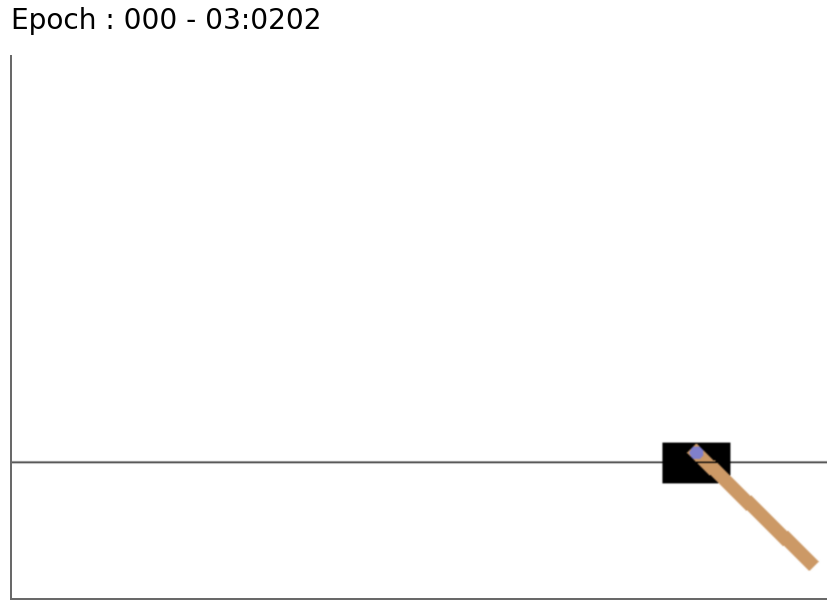

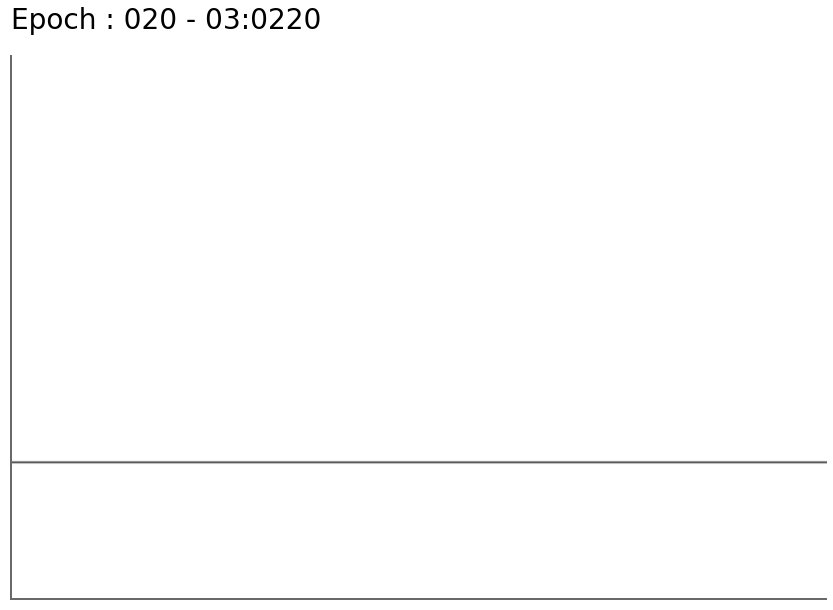

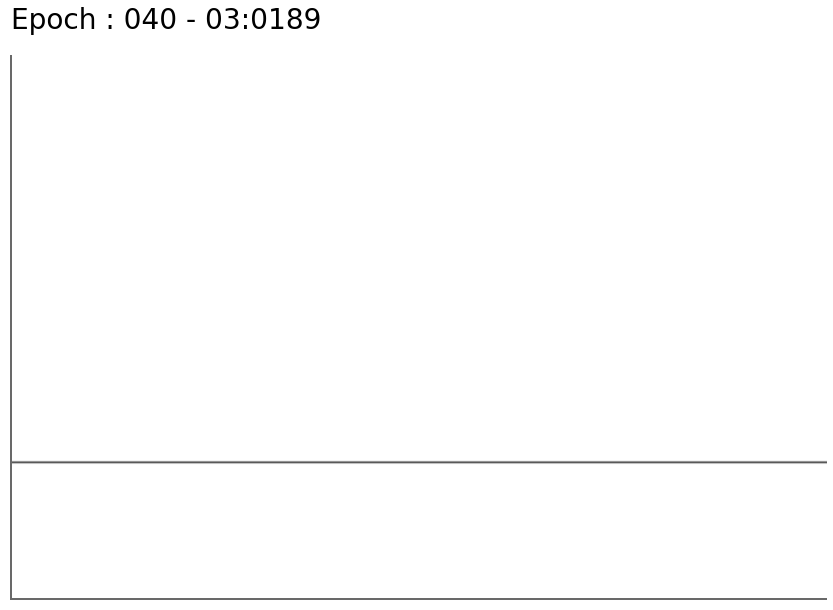

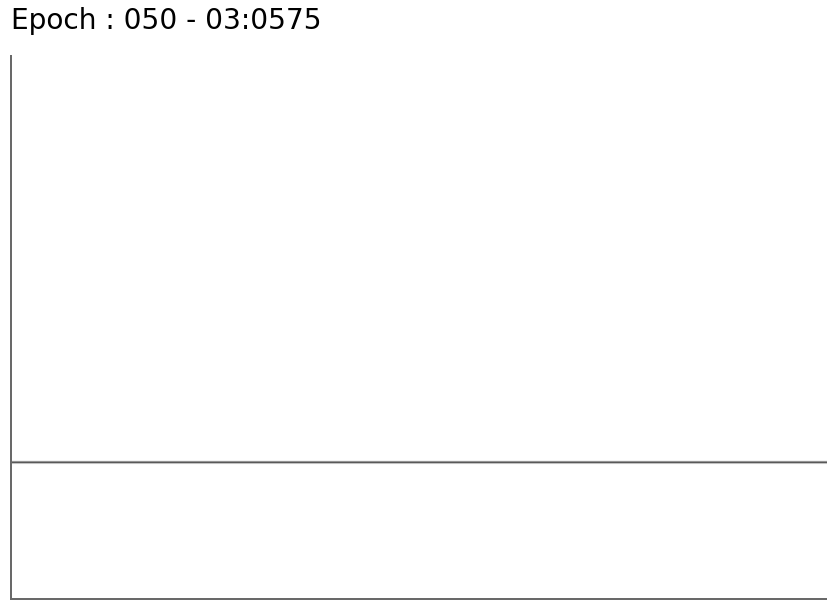

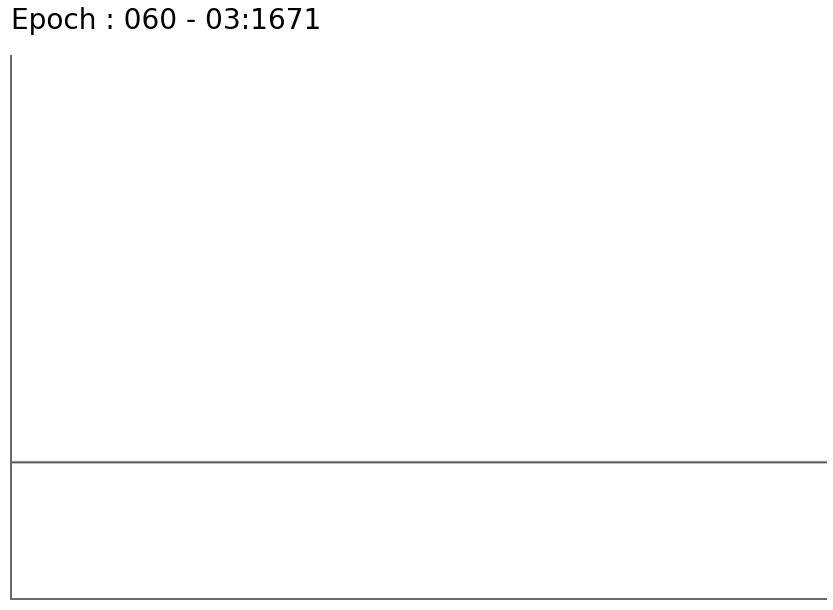

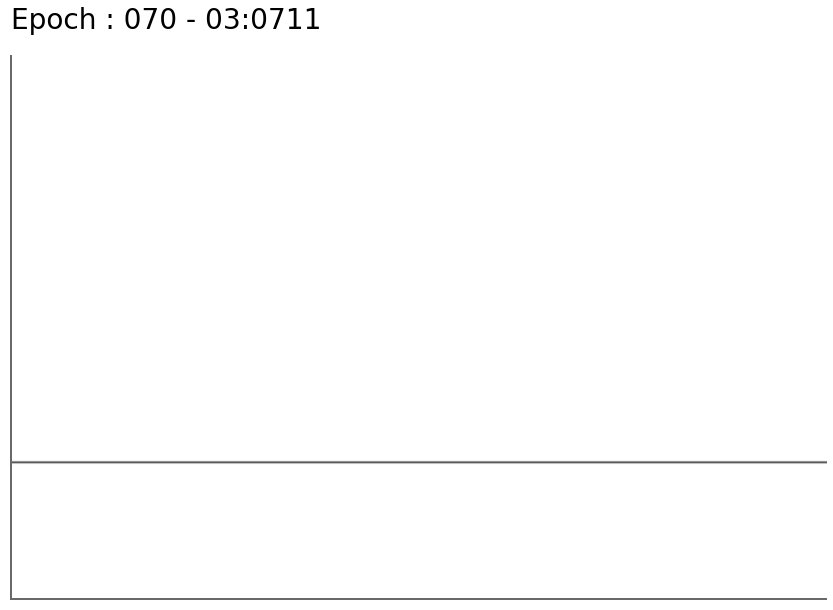

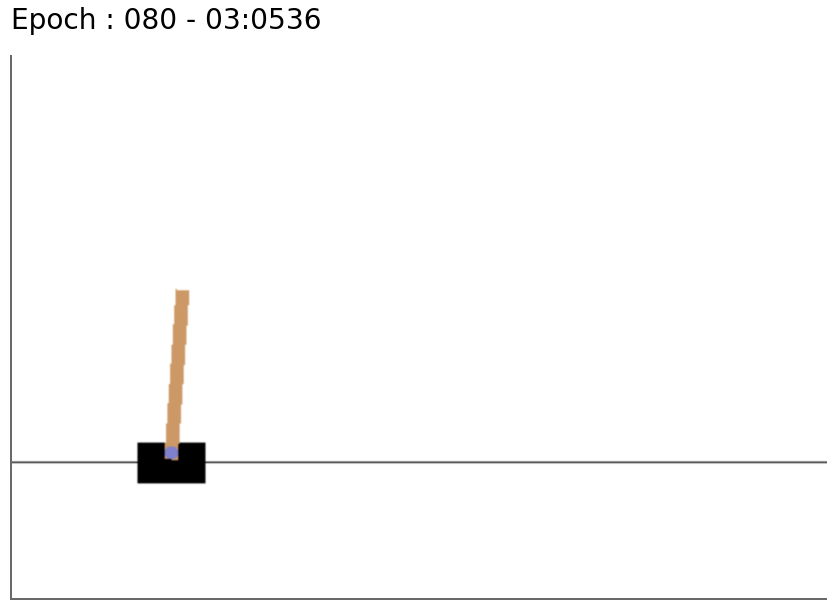

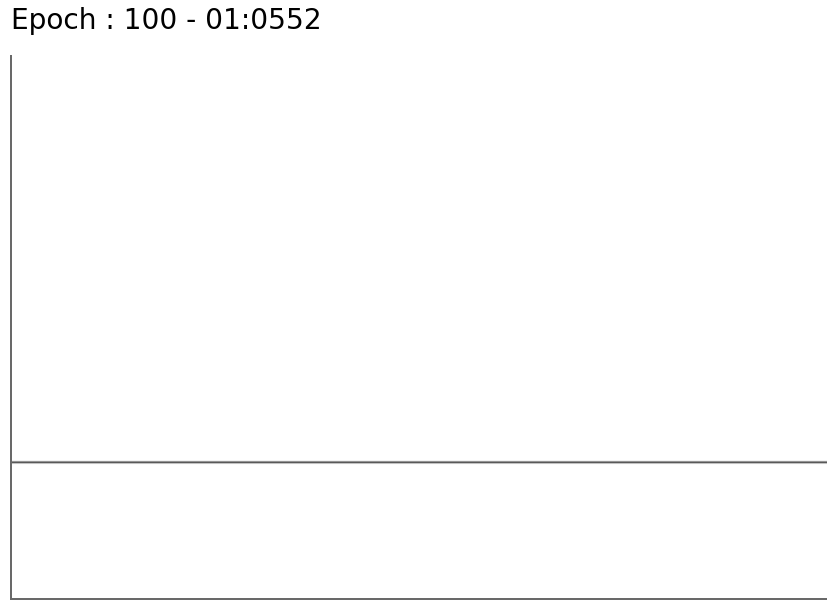

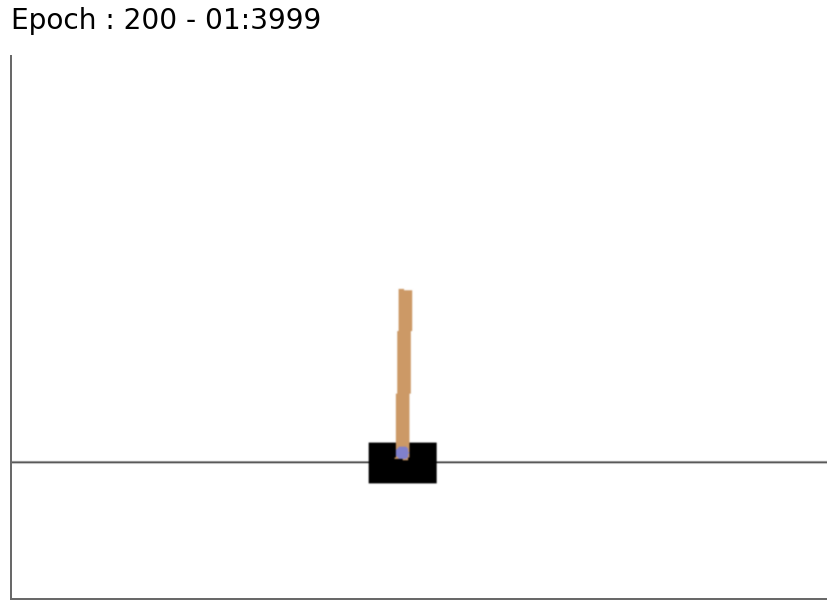

In [8]:
# %%capture
logging.disable(logging.WARNING)

if build_animations:
    
    run_model('0',  'Epoch : 000', pitch=0.00, nb_episodes=3)
    run_model('20', 'Epoch : 020', pitch=0.00, nb_episodes=3)
    run_model('40', 'Epoch : 040', pitch=0.00, nb_episodes=3)
    run_model('50', 'Epoch : 050', pitch=0.00, nb_episodes=3)
    run_model('60', 'Epoch : 060', pitch=0.00, nb_episodes=3)
    run_model('70', 'Epoch : 070', pitch=0.00, nb_episodes=3)
    run_model('80', 'Epoch : 080', pitch=0.00, nb_episodes=3)
    run_model('100','Epoch : 100', pitch=0.00, nb_episodes=1)
    run_model('200','Epoch : 200', pitch=0.00, nb_episodes=1)

else:
    print('Build animations is False.')